In [1]:
!pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185319 sha256=fdea7a865ddb2cbfaf516cfada83187247bfb3a76591192f0cd669305646ded6
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [2]:
%%writefile bifurcation.py
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

def bifurcation(r, x):
    return r * x * (1 - x)

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    start = MPI.Wtime()
    n = 1000000
    last = 20
    num_r_per_rank = n // size
    r = np.linspace(2.5 + rank / size * (4 - 2.5), 2.5 + (rank+1) / size * (4 - 2.5), num_r_per_rank)
    iterations = 10000
    x = 1e-5 * np.ones(num_r_per_rank)

    sendbuff_x = []
    sendbuff_r = []


    recvbuf_r = None
    recvbuf_x = None

    if rank == 0:
        recvbuf_r = np.empty((last, num_r_per_rank * size ), dtype='d')
        recvbuf_x = np.empty((last, num_r_per_rank * size ), dtype='d')

    for i in range(iterations):
        x = bifurcation(r, x)
        if i >= (iterations - last):
            sendbuff_x.append(x) #= x if sendbuff_x is None else np.vstack((sendbuff_x, x))
            sendbuff_r.append(r) #= r if sendbuff_r is None else np.vstack((sendbuff_r, r))


    comm.Gather(np.array(sendbuff_x), recvbuf_x, root = 0)
    comm.Gather(np.array(sendbuff_r), recvbuf_r, root = 0)
    end = MPI.Wtime()

    if rank == 0:
        print(f'Size is {size} time is {end - start}')
        fig, (ax1) = plt.subplots(1, 1)
        ax1.set_xlim(2.5, 4)
        ax1.set_title("Bifurcation diagram")
        for r, x in zip(recvbuf_r, recvbuf_x):
            ax1.plot(r, x, ',k', alpha=.25)
        plt.tight_layout()
        fig.savefig('bifurcation_map.png')
    
main()

Writing bifurcation.py


In [3]:
! mpirun --allow-run-as-root -np 1 python bifurcation.py
! mpirun --allow-run-as-root -np 2 python bifurcation.py
! mpirun --allow-run-as-root -np 3 python bifurcation.py
! mpirun --allow-run-as-root -np 4 python bifurcation.py
! mpirun --allow-run-as-root -np 5 python bifurcation.py
! mpirun --allow-run-as-root -np 6 python bifurcation.py
! mpirun --allow-run-as-root -np 7 python bifurcation.py
! mpirun --allow-run-as-root -np 8 python bifurcation.py

Size is 1 time is 42.359537354999986
Size is 2 time is 37.26429525399999
Size is 3 time is 36.67619556100004
Size is 4 time is 38.45385159800003
Size is 5 time is 36.39114715599999
Size is 6 time is 36.28174171499995
Size is 7 time is 36.124017202999994
Size is 8 time is 35.676010249


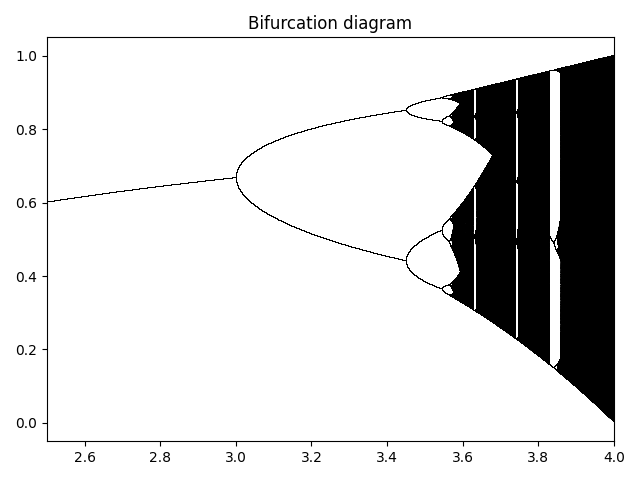

In [4]:
from PIL import Image
Image.open('bifurcation_map.png')

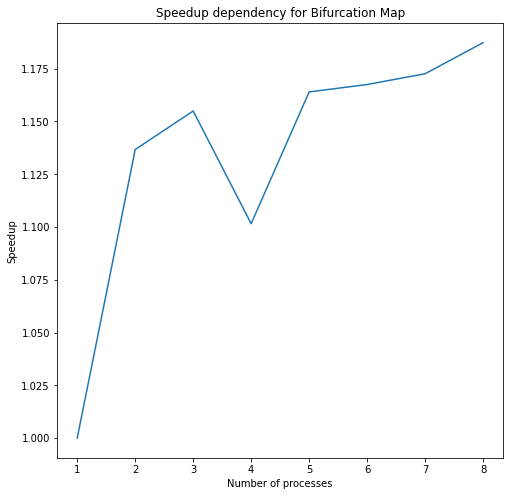

In [6]:
import matplotlib.pyplot as plt
times = [42.359537354999986,
37.26429525399999,36.67619556100004,38.45385159800003,36.39114715599999,36.28174171499995,36.124017202999994,
35.676010249]


plt.figure(figsize = (8, 8))
plt.plot([i for i in range(1, len(times)+1)], [times[0] / time for time in times])
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.title('Speedup dependency for Bifurcation Map')
plt.show()